This notebook collects all the game ID's from the Steam Web API: https://steamcommunity.com/dev and additional informattion from the third party API Steam Spy: https://steamspy.com/api.php.
Then 

In [4]:
import json
from urllib.request import urlopen
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

# variables
scrape_details = True # if data should be scraped or loaded from csv
num_apps = 1000 # number of reviews to scrape, if 0 all reviews will be scraped
all_games_url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
review_url = "https://store.steampowered.com/appreviews/"
app_details_url = "https://store.steampowered.com/api/appdetails?appids="

steam_spy_url = "https://steamspy.com/api.php?request=appdetails&appid=" # player number ...


In [5]:
# either scraping the data
if scrape_details:
    
    # get all app ID
    with urlopen(all_games_url) as url:
        apps = pd.json_normalize(json.load(url)["applist"], record_path =['apps'])

    # check if all should be scraped
    if num_apps == 0: num_apps = len(apps)
    
    # pre-clean, select num_apps entries
    apps = apps.drop(apps[apps.name == ""].index).head(num_apps)
    
    reviews = pd.DataFrame()
    details = pd.DataFrame()
    
    # iterate through the appids
    for appid in tqdm(apps.appid):
        
        # create specific detail url
        with urlopen(app_details_url + str(appid)) as url:
            
            # collect details
            app_details = json.load(url)[str(appid)]
            
            # if api call was successfull
            if app_details["success"]:
                
                # concat to details frame
                details = pd.concat([details, pd.DataFrame([app_details["data"]])])
                
                # create specific review url
                with urlopen(review_url + str(appid) + "?json=1") as url:
                    # concat to reviews frame
                    reviews = pd.concat([reviews, pd.DataFrame([json.load(url)['query_summary']])])
            
            else:
                # if detail call were not successfull delete row in app df
                apps = apps.drop(apps[apps.appid == appid].index) 
    
    # concate frames
    df = pd.DataFrame()
    df = pd.concat([apps.reset_index(drop=True), 
                    reviews.reset_index(drop=True),
                    details.reset_index(drop=True)], axis = 1)
    
    df.to_csv('raw_data.csv')

# or reading
else:
    df = pd.read_csv('raw_data.csv', index_col=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

HTTPError: HTTP Error 429: Too Many Requests

In [ ]:
# Cleaning the data
# games that have no reviews
df = df.drop(df[df.total_reviews == 0].index)

# games for which information was not fetched
df.to_csv('clean_data.csv')

Text(0.5, 1.0, 'Score distribution')

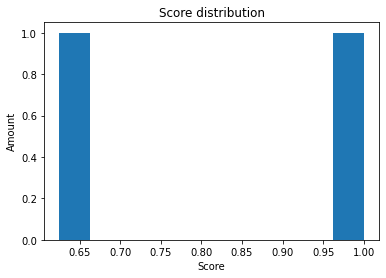

In [ ]:
# plot distribution
plt.hist((df.total_positive - df.total_negative)/df.total_reviews)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")